In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.io.fits as fits

import pysm3
import pysm3.units as u



import sys
sys.path.append('/home/rguidetti')
from PolAngle import *
from beam import * 
from map import *
from convolution import * 
from beam_class import *
from PatchFunctions import *  # nuove funzioni in quanto quelle vecchie lavoravano con mappe NxN. Queste funzionano per mappe rettangolari Nx,Ny

import lmfit 

# Power Spectra

In [14]:
'''
# Read the PS originated from the Common_notebook
Original_PS = np.loadtxt('Original_PS_001.txt')


TT_ps  = Original_PS[0]
TE_ps  = Original_PS[1]
EE_ps  = Original_PS[2]
BB_ps  = Original_PS[3]
BB_ps_tensor  = Original_PS[4]



#plot the total CMB power spectra
ls = np.arange(TT_ps.shape[0])
'''

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0.001)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
pars.WantTensors= True

#calculate results for these parameters
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

totCL = powers['total']
unlensedCL = powers['unlensed_scalar']
tensor = powers['tensor']
print(totCL.shape)

ls = np.arange(totCL.shape[0])
#fig, ax = plt.subplots(2,2, figsize = (8,8))

# rinomino per comodità
TT_ps  = totCL[:,0] 
TE_ps  = totCL[:,3] 
EE_ps  = totCL[:,1] 
BB_ps  = totCL[:,2]
BB_ps_tensor  = tensor[:,2]

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential
(2551, 4)


# Maps

In [15]:
# MAP PARAMETERS

pix_size         = 0.5                              #arcmin
N                = 2**10                            #num pixel lineare
X_width, Y_width = N*pix_size/60., N*pix_size/60.   #dimensioni mappa in gradi
Nsqdeg           = X_width**2

c_min, c_max     = -200, 200                        #color map

print(f"Map with {N} x {N} pixels, each of {pix_size} arcmin, for a total dimension of {X_width:.2f} x {Y_width:.2f} gradi")


nbig = 5000

Map with 1024 x 1024 pixels, each of 0.5 arcmin, for a total dimension of 8.53 x 8.53 gradi


In [16]:

# ORIGINAL MAPS

ell_big = np.arange(nbig)

TT_ps_big = np.zeros(nbig)
TT_ps_big[ls.astype(int)] = TT_ps

EE_ps_big = np.zeros(nbig)
EE_ps_big[ls.astype(int)] = EE_ps

BB_ps_big = np.zeros(nbig)
BB_ps_big[ls.astype(int)] = BB_ps

TE_ps_big = np.zeros(nbig)
TE_ps_big[ls.astype(int)] = TE_ps

ell    = ell_big
ps_TT  = TT_ps_big + 1e-3   
ps_EE  = EE_ps_big + 1e-3
ps_BB  = BB_ps_big + 1e-3
ps_TE  = TE_ps_big

Temp_point_source_spectrum = ps_TT[1000]*(ell/3000.)**2.
Pol_point_source_spectrum  = ps_EE[1500]*(ell/4500.)**2.

ps_TT = ps_TT + Temp_point_source_spectrum  
ps_EE = ps_EE + Pol_point_source_spectrum
ps_BB = ps_BB + Pol_point_source_spectrum



T_map, Q_map, U_map, E_map, B_map = make_CMB_maps(N,pix_size,ell,ps_TT,ps_EE,ps_TE,ps_BB)

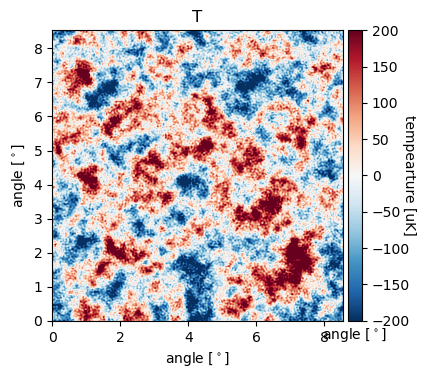

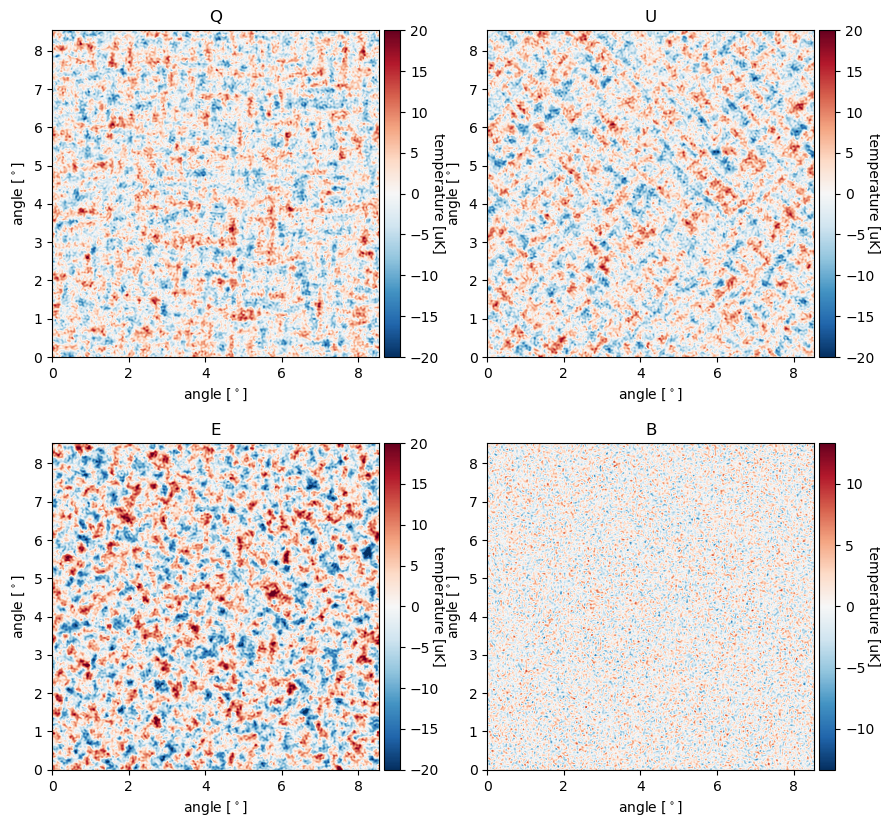

In [17]:
plt.title("T")
plt.ylabel('angle $[^\circ]$')
plt.xlabel('angle $[^\circ]$')
p = Plot_CMB_Map(T_map,c_min,c_max,X_width,Y_width)



Map_to_Plot = [Q_map, U_map, E_map, B_map]
title = ["Q","U","E", "B"]
c_factor = [10, 10, 10,15]

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
axs      = axs.flatten()
for i, (map_data, c_factor_iter) in enumerate(zip(Map_to_Plot, c_factor)):
        Plot_CMB_Map_compact(axs[i], map_data, c_min/c_factor_iter, c_max/c_factor_iter, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
#plt.suptitle('Maps convolution with beam', fontsize=20)
plt.show()

# Beam
Simulation of a realistic beam with a gaussian center peak and secondary peaks
https://github.com/McMahonCosmologyGroup/cmbInstrumentSummerSchool/blob/main/Notebook2_beam_systematics.ipynb

In [18]:
# COORDINATES LIKE THE ONES OF THE MAPS

N = int(N)
ones = np.ones(N)
inds = (np.arange(N)+.5 - N/2.) * pix_size
X = np.outer(ones,inds)
Y = np.transpose(X)
R = np.sqrt(X**2. + Y**2.)


#####################################################################################

# VARIABLES

FWHM_x = 4  # degrees
FWHM_y = 5  # degrees

ellipticity = (FWHM_x - FWHM_y) / (FWHM_x + FWHM_y)
print("ellipticity = ", ellipticity)

array_dB = np.array([-20, -24, -28, -32])  #max values of the secondary peaks
#array_dB = array_dB *1.5
r1 = np.array([20, 50, 90, 130]) #angular distance of the peaks
r = 2 # width of the rings

theta = 0 # angle of rotation of the beam
a = 1 # major axis of ellipses 


#########################################################################################

# BEAM

beam_gauss_x, beam_gauss_y, sec_rings_x,sec_rings_y, beam_x, beam_y = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, theta, array_dB, r, r1, X, Y, a, ellipticity)

ellipticity =  -0.1111111111111111


beam max: 4.342923104481638e-05 beam min: 4.142748026926061
beam max: 4.342923104481638e-05 beam min: 4.1427480269260615


0

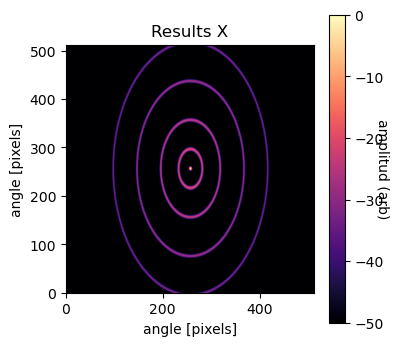

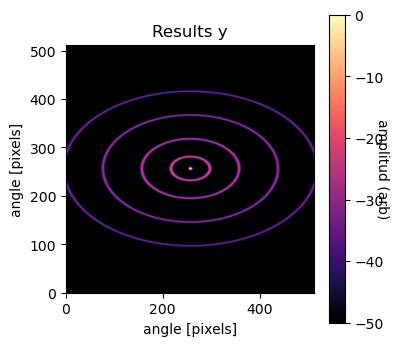

In [19]:
beam_to_plot = beam_x
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),N,pix_size,512, "Results X", "angle [pixels]")

beam_to_plot = beam_y
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),N,pix_size,512, "Results y", "angle [pixels]")

### Beam systematics

In [20]:
### beam systematics dictionary
bs = {"budy":{"A":1e-3,"FWHP":1.5,"R":50.,"psi":0.3,"polfracQ":0.5,"polfracU":0.01},  
                                                                         # little budy amplitude, 
                                                                         #FWHP, offset spacing, rotationa angle (radians)
                                                                        # pol_fraction for Q and U
     "ghostshelf": {"A":1e-10,"Diam":10.,"roll_off":7.},    #model of ghosting, amplitude (A), diameter (Diam) 
     "hex_crostalk":{"grid_space": 3.5,"N":5,"neighbor_exp_fall":0.01}, 
                                                                               ## model of optical cross talk 
                                                                               ## to detectors on a hex grid
                                                                               ## assumed to be exponetial
                                                                               ## assumed to be 50% polarized
      "TtoQ":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
      "TtoU":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
                                                                  ## multiplole expansion leakage
      'psi':0.01*np.pi/180.
                                  ## detetor angle rotations
                   }

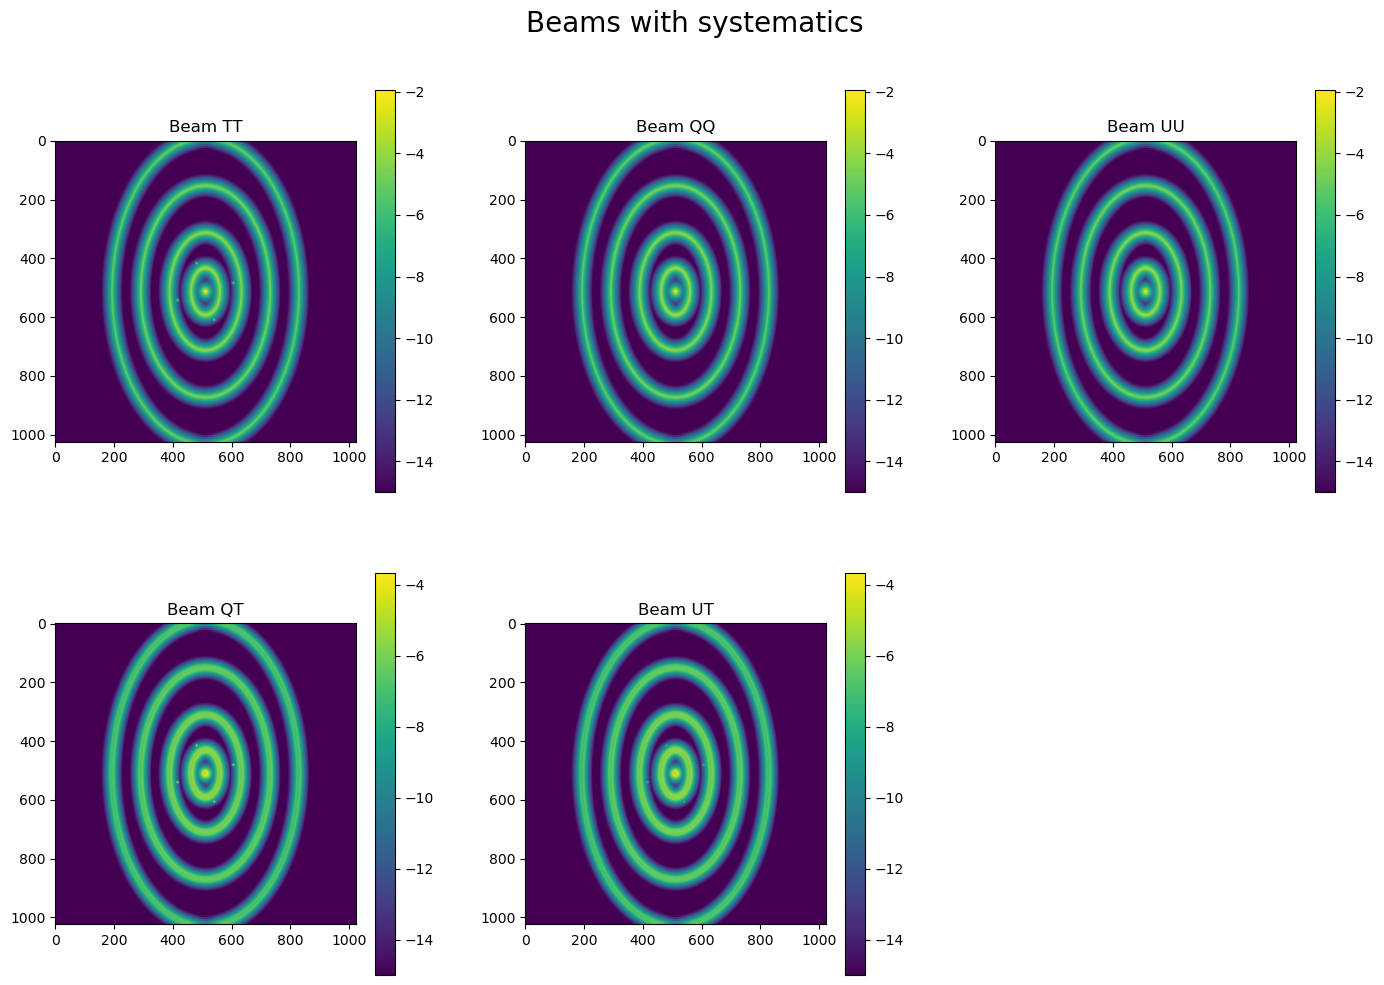

In [21]:
beam_sys = BeamSystematics()
beam_TT, beam_QQ, beam_UU, beam_QT, beam_UT, beam_QU, beam_UQ = beam_sys.make_systematics_beams(N, pix_size, FWHM_x, beam_x, bs)


Map_to_Plot = [beam_TT, beam_QQ, beam_UU, beam_QT, beam_UT]
title = ["Beam TT", "Beam QQ", "Beam UU", "Beam QT", "Beam UT" ]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3]), np.max(Map_to_Plot[4])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3]), np.min(Map_to_Plot[4])]


fig, axs = plt.subplots(2, 3, figsize=(14, 10))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
    im = axs[i].imshow(np.log10(map_data+1e-15))
    axs[i].set_title(title[i])
    plt.colorbar(im, ax=axs[i], orientation='vertical')
    
fig.delaxes(axs[-1])
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle(f'Beams with systematics', fontsize=20)
plt.show()

### Convolve map with beam

In [22]:
## MAPS IN THE REAL SPACE

# convolution with perfect beam
perf_beam, no1, no2, no3, no4, no5 = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, 0, array_dB, r, r1, X, Y, a, ellipticity)
perf_beam = perf_beam / np.sum(perf_beam)

Q_conv_perf = convolve_map_with_beam(Q_map, perf_beam)
U_conv_perf = convolve_map_with_beam(U_map, perf_beam)


# convolution with real beam
Q_conv_real = convolve_map_with_beam(Q_map, beam_QQ)
U_conv_real = convolve_map_with_beam(U_map, beam_UU)

# POLARIZATION ANGLE SYSTEMATICS

In [23]:
std_deviation_degree = 0.1
std_deviation_rad   = std_deviation_degree * np.pi / 180
gauss_center  = 0

print(std_deviation_rad)

0.0017453292519943296


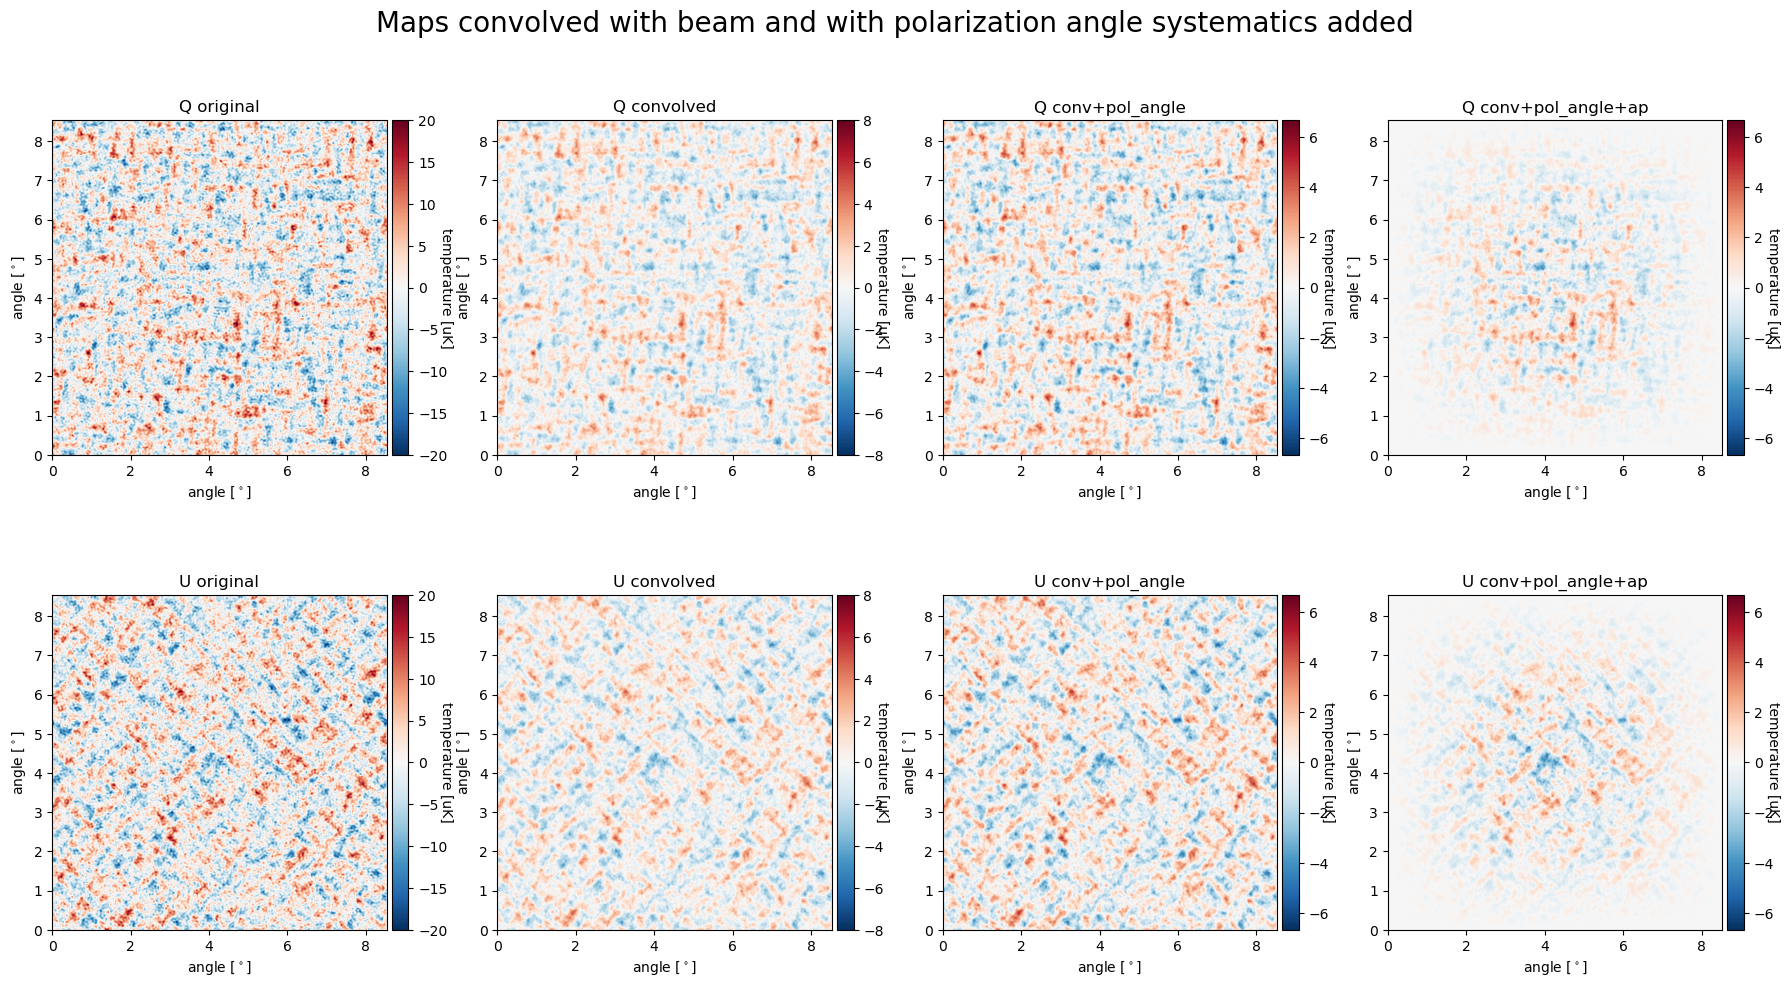

In [24]:
# POLARIZATION ANGLE
 
Q_pert, U_pert = polangle_map(Q_conv_real, U_conv_real, gauss_center, std_deviation_rad)
#Q_map_pert_perf, U_map_pert_perf = polangle_map(Q_conv_perf, U_conv_perf, gauss_center, std_deviation_rad)

########################################################################################################

# APODIZATION
window = (cosine_window(N))
Q_ap = window * Q_pert
U_ap = window * U_pert

########################################################################################################

# plot
Map_to_Plot = [Q_map, Q_conv_real,Q_pert,Q_ap, U_map, U_conv_real ,U_pert, U_ap]
title = ["Q original","Q convolved","Q conv+pol_angle", "Q conv+pol_angle+ap", "U original","U convolved", "U conv+pol_angle", "U conv+pol_angle+ap"]
c_factor = [10, 25, 30,30, 10, 25,30, 30]

fig, axs = plt.subplots(2, 4, figsize=(18, 10))
axs      = axs.flatten()
for i, (map_data, c_factor_iter) in enumerate(zip(Map_to_Plot, c_factor)):
        Plot_CMB_Map_compact(axs[i], map_data, c_min/c_factor_iter, c_max/c_factor_iter, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle('Maps convolved with beam and with polarization angle systematics added', fontsize=20)
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelPerturbation.png')
plt.show()

# ANALYSIS

### Deconvolution

In [25]:
#Q_deconv = deconvolve_map(Q_ap/window, beam_QQ, perf_beam)
#U_deconv = deconvolve_map(U_ap/window, beam_UU, perf_beam)

Q_deconv = correct_lr(Q_ap/window, perf_beam,N, pix_size, 'onestep', None, 1e-10, 1e-12, None, 50)
U_deconv = correct_lr(U_ap/window, perf_beam,N, pix_size, 'onestep', None, 1e-10, 1e-12, None, 50)

In [26]:
# DIFFERENCE
Q_diff = (Q_conv_perf- Q_deconv)
U_diff = (U_conv_perf- U_deconv)

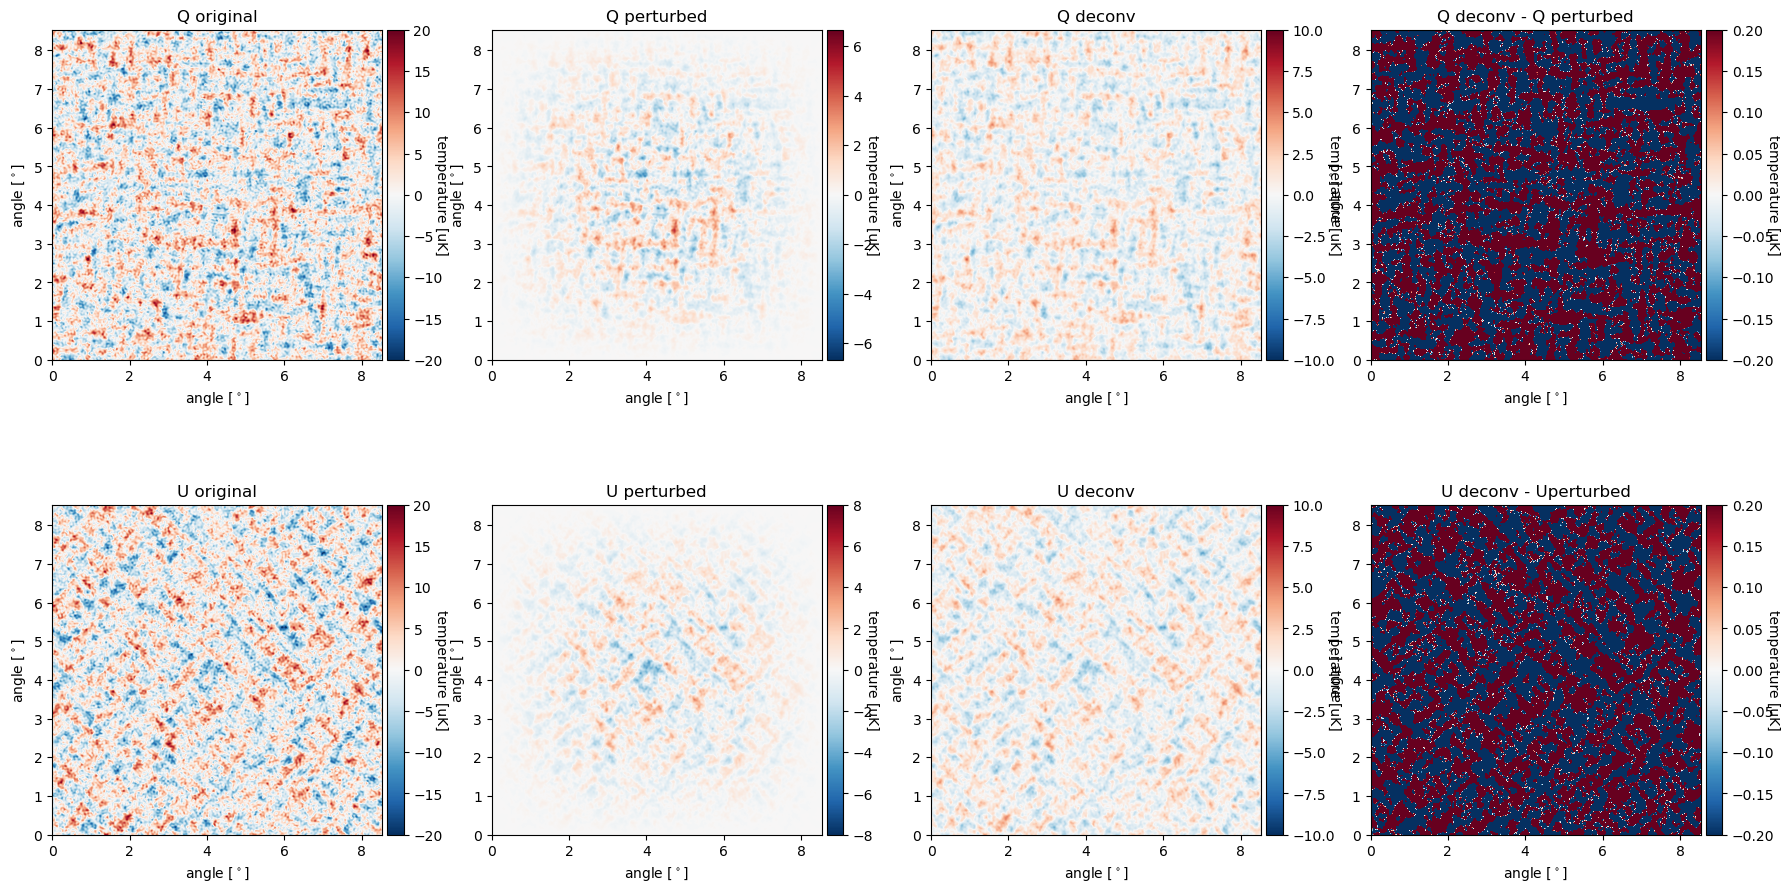

In [27]:
# plot
Map_to_Plot = [Q_map,Q_ap, Q_deconv, Q_diff, U_map, U_ap, U_deconv, U_diff]
title = ["Q original", "Q perturbed", "Q deconv", "Q deconv - Q perturbed", "U original","U perturbed", "U deconv", "U deconv - Uperturbed"]
c_factor = [10,30, 20, 1e3, 10, 25,20, 1e3]

fig, axs = plt.subplots(2, 4, figsize=(18, 10))
axs      = axs.flatten()
for i, (map_data, c_factor_iter) in enumerate(zip(Map_to_Plot, c_factor)):
        Plot_CMB_Map_compact(axs[i], map_data, c_min/c_factor_iter, c_max/c_factor_iter, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
#plt.suptitle('Maps convolved with beam and with polarization angle systematics added', fontsize=20)
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelDeconv.png')
plt.show()

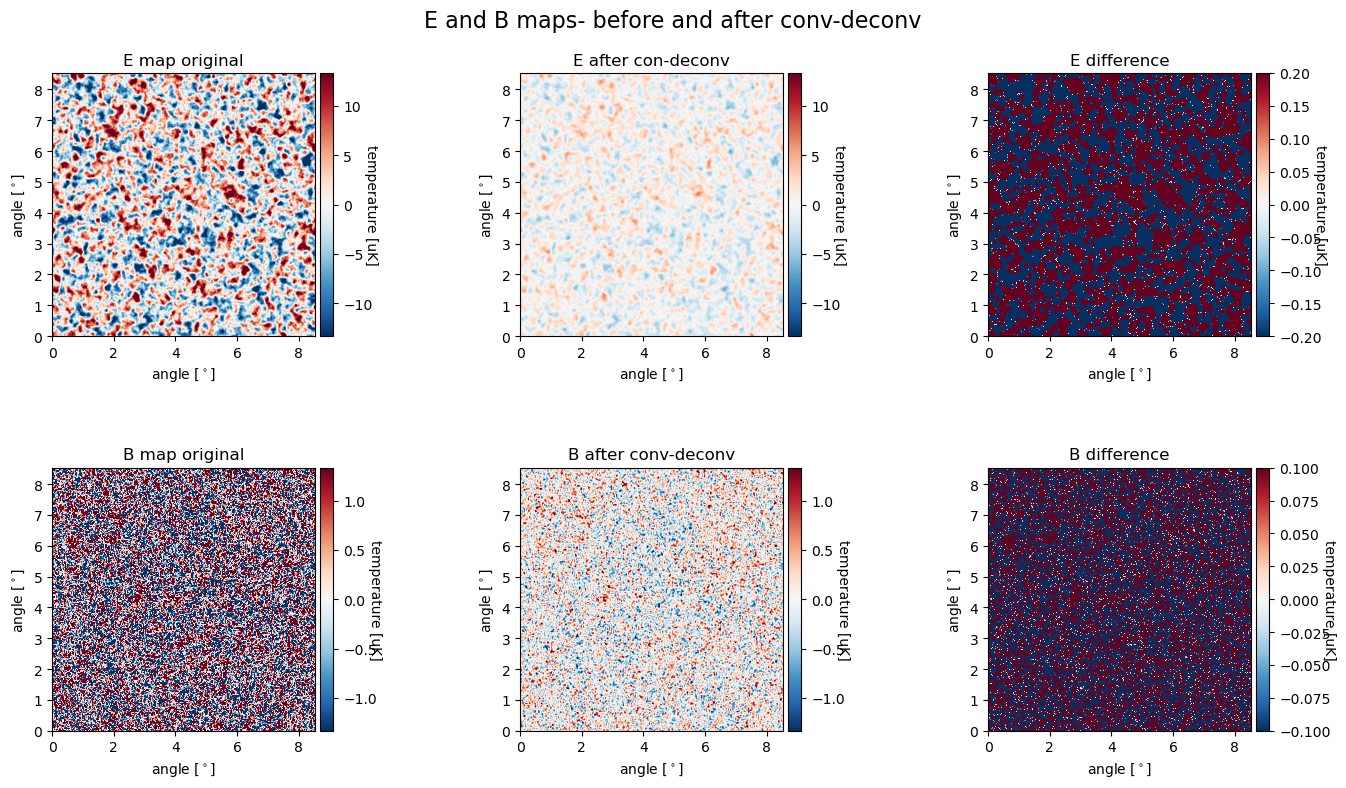

In [28]:
# FROM QU TO EB (beam + pol_angle)
E_deconv, B_deconv = QU2EB(N,pix_size,Q_deconv,U_deconv)

E_diff, B_diff     = QU2EB(N,pix_size,Q_diff,U_diff)

E_conv, B_conv     = QU2EB(N,pix_size,Q_conv_perf,U_conv_perf)

#E_conv = convolve_map_with_beam(E_map, perf_beam)
#B_conv = convolve_map_with_beam(B_map, perf_beam)



map_list      = [E_conv, E_deconv, E_diff, B_conv, B_deconv, B_diff] 
title_list    = ["E map original", "E after con-deconv", "E difference", "B map original", "B after conv-deconv", "B difference"]
color_rescale = [15, 15, 1e3, 150, 150, 2e3]

fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs      = axs.flatten()

for i, map_data in enumerate(map_list):

        Plot_CMB_Map_compact(axs[i], map_data, c_min/color_rescale[i], c_max/color_rescale[i], X_width, Y_width)
        axs[i].set_title(title_list[i])
        
        
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.5, top=0.90)
plt.suptitle('E and B maps- before and after conv-deconv', fontsize=16)
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelEB.png')
plt.show()

In [29]:
delta_l = 50.
l_max   = 2500

# Power spectra deconvolved maps
binned_l_E_deconv, binned_spectrum_E_deconv = calculate_2d_spectrum(E_deconv,E_deconv,delta_l,l_max,pix_size,N)
binned_l_B_deconv, binned_spectrum_B_deconv = calculate_2d_spectrum(B_deconv,B_deconv,delta_l,l_max,pix_size,N)

# Power spectra difference maps - to obtain the side lobes
binned_l_Ediff, binned_spectrum_Ediff = calculate_2d_spectrum(E_diff,E_diff,delta_l,l_max,pix_size,N)
binned_l_Bdiff, binned_spectrum_Bdiff = calculate_2d_spectrum(B_diff,B_diff,delta_l,l_max,pix_size,N)

# Power spectra of maps convolved with a perfect beam to compare better with the deconvolved power spectra
binned_l_E_conv, binned_spectrum_E_conv = calculate_2d_spectrum(E_conv,E_conv,delta_l,l_max,pix_size,N)
binned_l_B_conv, binned_spectrum_B_conv = calculate_2d_spectrum(B_conv,B_conv,delta_l,l_max,pix_size,N)

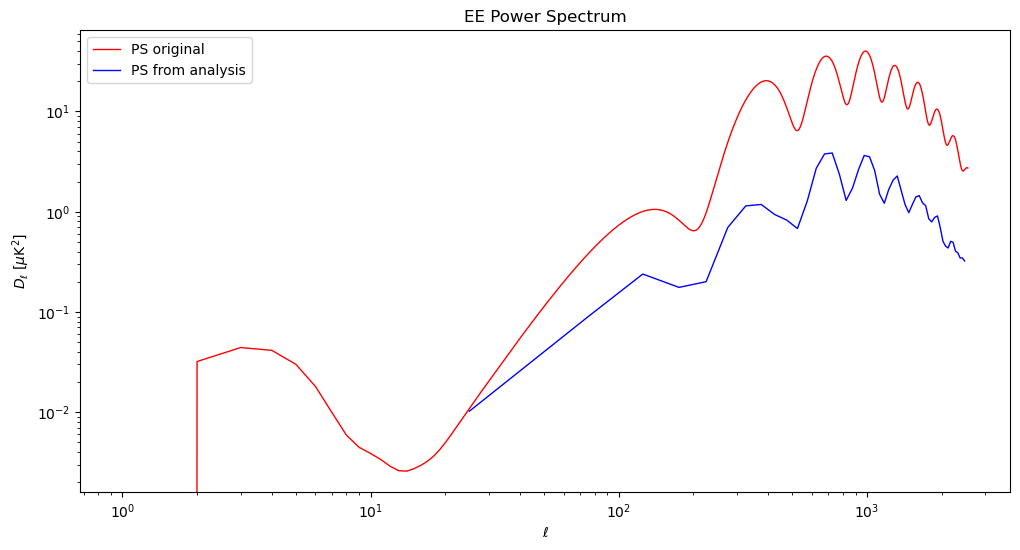

In [30]:
# EE
plt.figure(figsize=(12, 6))

# PS originale da camb
plt.loglog(ls,Original_PS[2], label="PS original", c="r", linewidth=1)

# PS dalle mappe convolute - deconvolute con beam con sistematiche
plt.loglog(binned_l_E_deconv, binned_spectrum_E_deconv* binned_l_E_deconv * (binned_l_E_deconv+1.)/2. / np.pi,color='b', linewidth =1,label="PS from analysis")

# PS da mappe quasi originali, perchè convolute con un beam perfetto
#plt.semilogy(binned_l_E_conv, binned_spectrum_E_conv* binned_l_E_conv * (binned_l_E_conv+1.)/2. / np.pi,color='black', label="PS original, convolved")




plt.title("EE Power Spectrum")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelEPS.png')
plt.show()

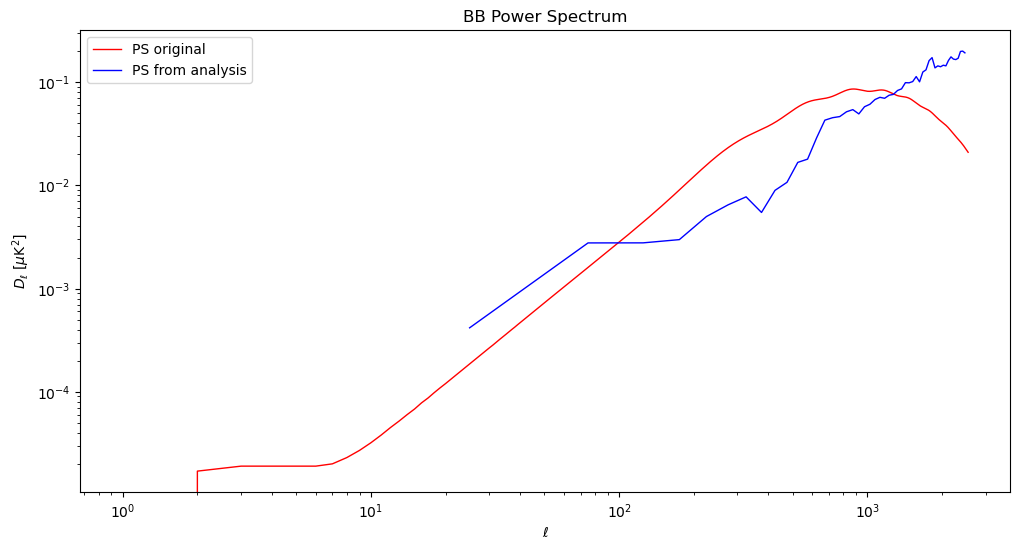

In [31]:
# BB
plt.figure(figsize=(12, 6))

# PS originale da camb
plt.loglog(ls,Original_PS[3], label="PS original", c="r", linewidth=1)

# PS dalle mappe convolute - deconvolute con beam con sistematiche
plt.loglog(binned_l_B_deconv, binned_spectrum_B_deconv* binned_l_B_deconv * (binned_l_B_deconv+1.)/2. / np.pi,color='b', linewidth =1,label="PS from analysis")

# PS da mappe quasi originali, perchè convolute con un beam perfetto
#plt.semilogy(binned_l_B_conv, binned_spectrum_B_conv* binned_l_B_conv * (binned_l_B_conv+1.)/2. / np.pi,color='black', label="PS original, convolved")



plt.title("BB Power Spectrum")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelBPS.png')
plt.show()

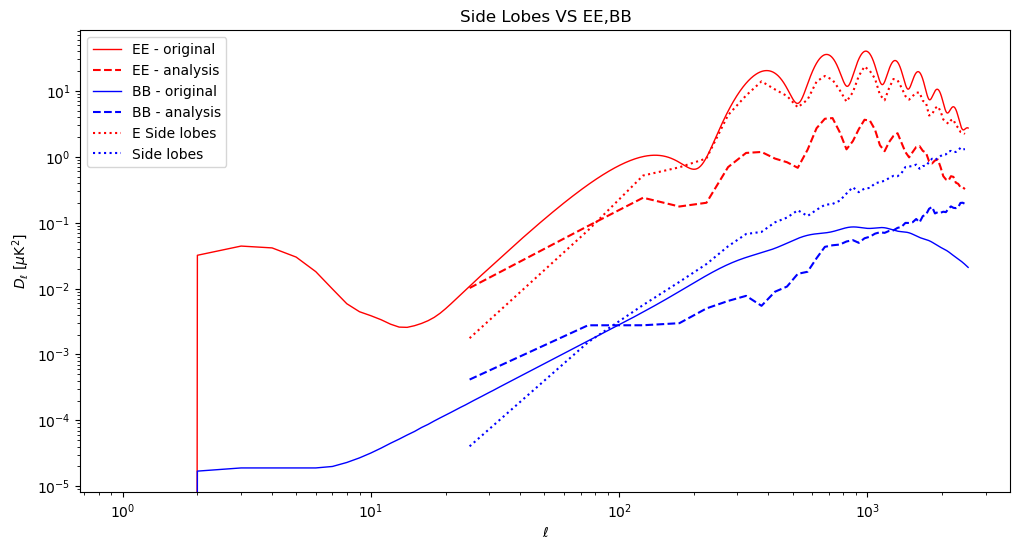

In [32]:
plt.figure(figsize=(12, 6))

# EE
plt.loglog(ls,Original_PS[2], label="EE - original", c="r", linewidth=1)
plt.loglog(binned_l_E_deconv, binned_spectrum_E_deconv* binned_l_E_deconv * (binned_l_E_deconv+1.)/2. / np.pi,color='r', linestyle="--",label="EE - analysis")

#BB
plt.loglog(ls,Original_PS[3], label="BB - original", c="b", linewidth=1)
plt.loglog(binned_l_B_deconv, binned_spectrum_B_deconv* binned_l_B_deconv * (binned_l_B_deconv+1.)/2. / np.pi,color='b', linestyle="--", label="BB - analysis")

# SIDE LOBES
plt.loglog(binned_l_Ediff, binned_spectrum_Ediff* binned_l_Ediff * (binned_l_Ediff+1.)/2. / np.pi,color='red', linestyle=":", label="E Side lobes")
plt.loglog(binned_l_Bdiff, binned_spectrum_Bdiff* binned_l_Bdiff * (binned_l_Bdiff+1.)/2. / np.pi,color='blue', linestyle=":", label="Side lobes")



plt.title("Side Lobes VS EE,BB")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelLobesPS.png')
plt.show()

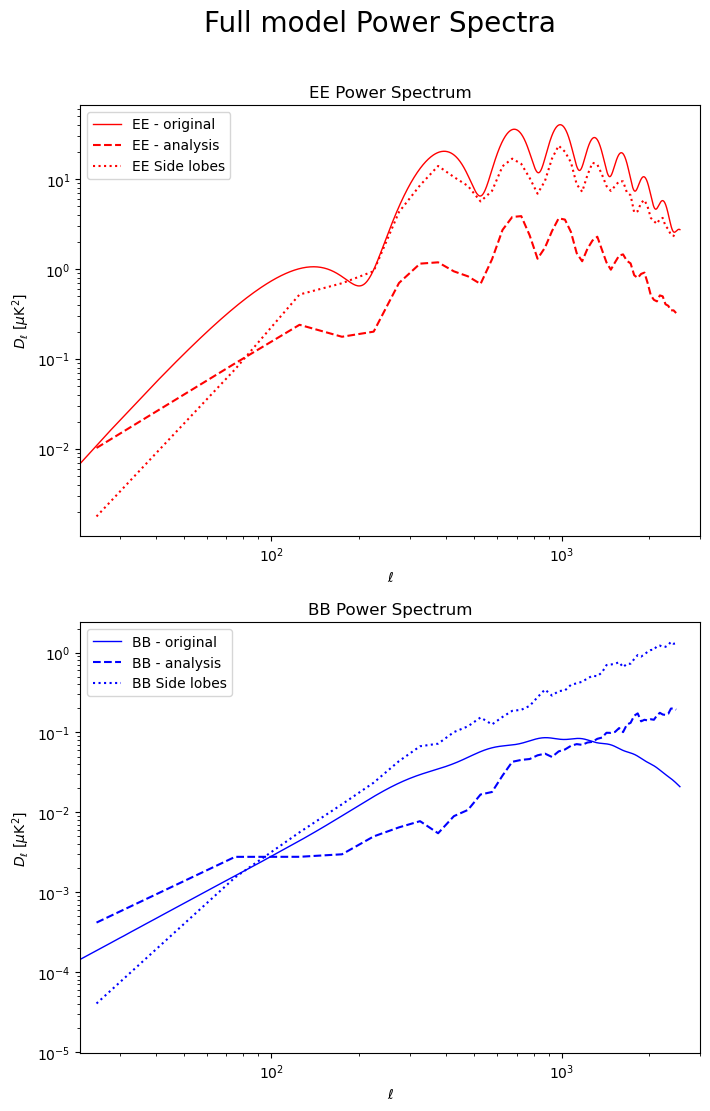

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(8, 12))

# Primo subplot - EE Power Spectrum
axs[0].loglog(ls,Original_PS[2], label="EE - original", c="r", linewidth=1)
axs[0].loglog(binned_l_E_deconv, binned_spectrum_E_deconv* binned_l_E_deconv * (binned_l_E_deconv+1.)/2. / np.pi,color='r', linestyle="--",label="EE - analysis")
axs[0].loglog(binned_l_Ediff, binned_spectrum_Ediff* binned_l_Ediff * (binned_l_Ediff+1.)/2. / np.pi,color='red', linestyle=":", label="EE Side lobes")

axs[0].set_title("EE Power Spectrum")
axs[0].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]')
axs[0].set_xlabel('$\ell$')
axs[0].legend()
axs[0].set_xlim(22,3000)
# Secondo subplot - BB Power Spectrum
axs[1].loglog(ls,Original_PS[3], label="BB - original", c="b", linewidth=1)
axs[1].loglog(binned_l_B_deconv, binned_spectrum_B_deconv* binned_l_B_deconv * (binned_l_B_deconv+1.)/2. / np.pi,color='b', linestyle="--", label="BB - analysis")
axs[1].loglog(binned_l_Bdiff, binned_spectrum_Bdiff* binned_l_Bdiff * (binned_l_Bdiff+1.)/2. / np.pi,color='blue', linestyle=":", label="BB Side lobes")

axs[1].set_title("BB Power Spectrum")
axs[1].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]')
axs[1].set_xlabel('$\ell$')
axs[1].legend()
axs[1].set_xlim(22,3000)

plt.title("BB Power Spectrum")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.9)
plt.suptitle(f'Full model Power Spectra', fontsize=20)
plt.show()

# Full figure - maps

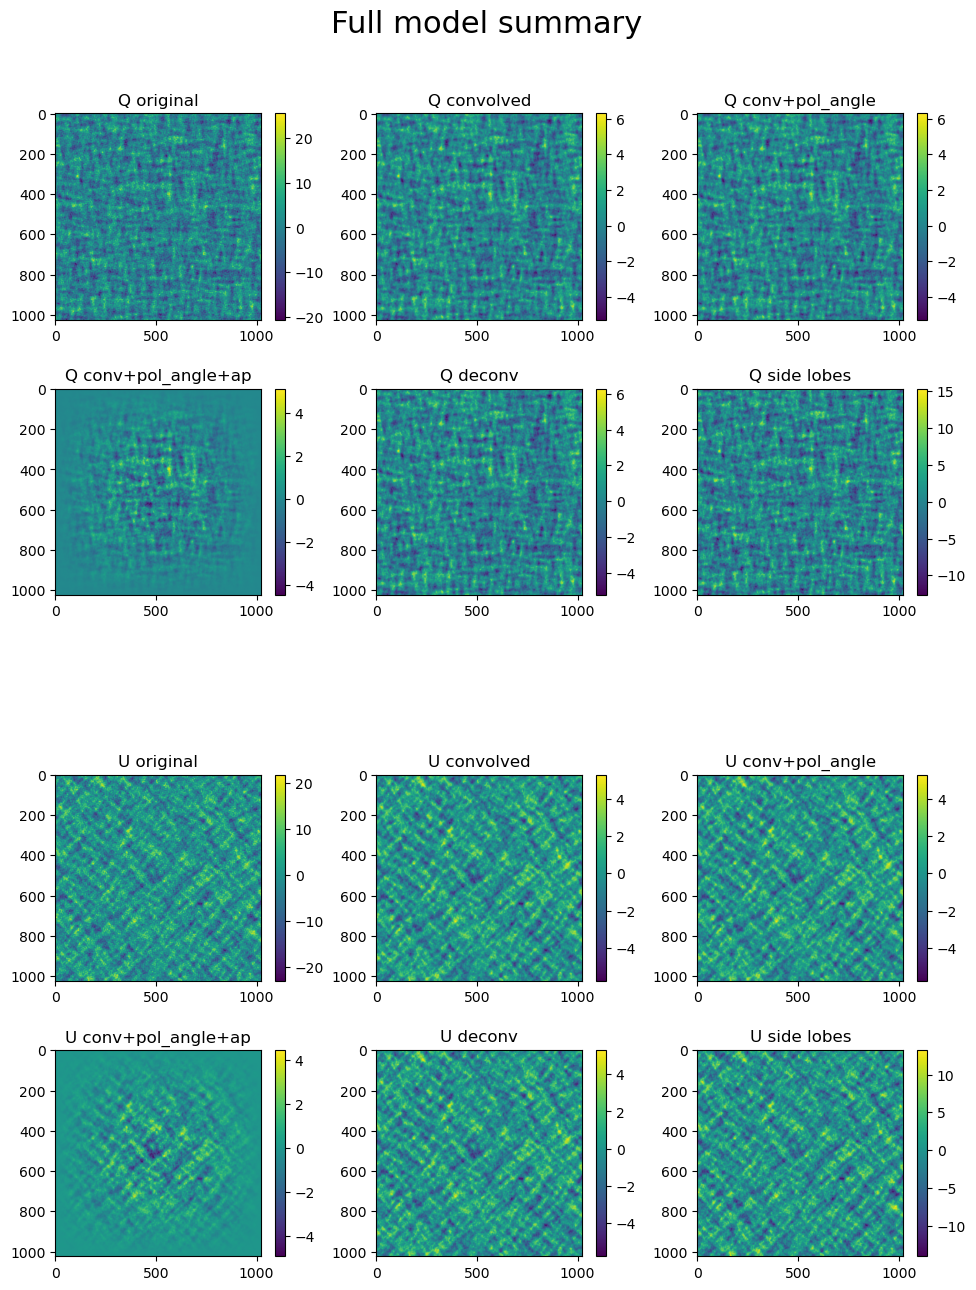

In [35]:
Map_to_Plot_1 = [Q_map, Q_conv_real, Q_pert, Q_ap, Q_deconv, Q_diff]
Map_to_Plot_2 = [U_map, U_conv_real ,U_pert, U_ap, U_deconv, U_diff]


title = ["Q original","Q convolved", "Q conv+pol_angle", "Q conv+pol_angle+ap", "Q deconv", "Q side lobes",
         "U original","U convolved", "U conv+pol_angle", "U conv+pol_angle+ap", "U deconv", "U side lobes"]

c_factor_max_1 = [np.max(Map_to_Plot_1[i]) for i in range(6)]
c_factor_min_1 = [np.min(Map_to_Plot_1[i]) for i in range(6)]

c_factor_max_2 = [np.max(Map_to_Plot_2[i]) for i in range(6)]
c_factor_min_2 = [np.min(Map_to_Plot_2[i]) for i in range(6)]

fig = plt.figure(figsize=(10, 13))
gs = fig.add_gridspec(5, 3, height_ratios=[1, 1, 0.2, 1, 1])  # The third row is for the empty space

axs = []
for i in range(2):  
    for j in range(3):
        ax = fig.add_subplot(gs[i, j])
        axs.append(ax)

for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot_1, c_factor_min_1, c_factor_max_1)):
    im = axs[i].imshow(map_data, vmin=c_factor_iter_min, vmax=c_factor_iter_max)
    axs[i].set_title(title[i])
    plt.colorbar(im, ax=axs[i], orientation='vertical')

axs = []
for i in range(3, 5):  # Rows 4 and 5
    for j in range(3):
        ax = fig.add_subplot(gs[i, j])
        axs.append(ax)

for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot_2, c_factor_min_2, c_factor_max_2)):
    im = axs[i].imshow(map_data, vmin=c_factor_iter_min, vmax=c_factor_iter_max)
    axs[i].set_title(title[6+i])
    plt.colorbar(im, ax=axs[i], orientation='vertical')


plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.4, top=0.9)
plt.suptitle(f'Full model summary', fontsize=22)
plt.show()
